In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.index = pd.to_datetime(df['datetime'])
df = df.drop('datetime', axis = 1)

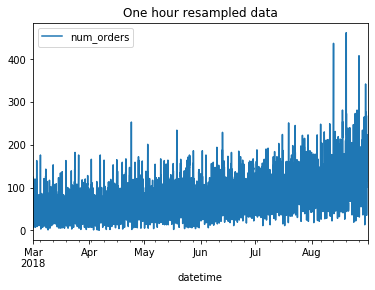

In [4]:
df.sort_index(inplace = True)
df = df.resample('1H').sum()
df.plot()
plt.title('One hour resampled data')
plt.show()

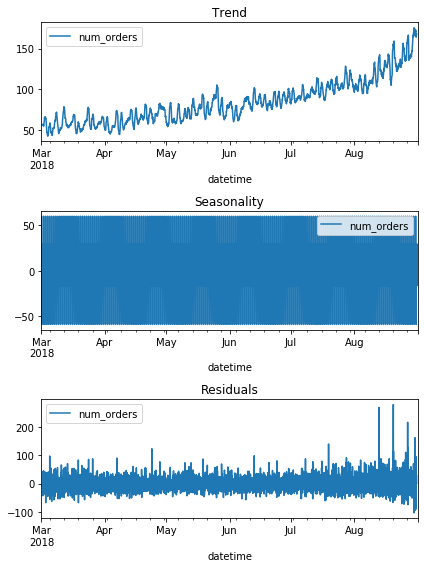

In [5]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

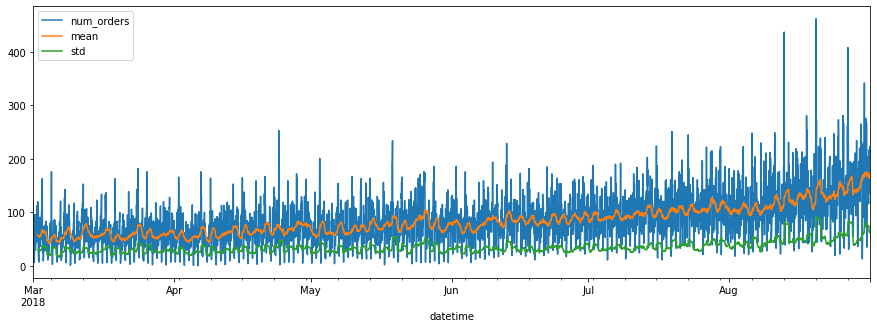

In [6]:
df['mean'] = df.rolling(25).mean()
df['std'] = df['num_orders'].rolling(25).std()
df.plot(figsize = (15,5))
plt.show()

Проверим гипотезу о стационарности временного ряда. Проведем тест Дикки-Фуллера и увидим p-value
##### H0 - ряд стационарен
##### H1 - ряд не стационарен


In [7]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['num_orders'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

if dfoutput[1] < 0.5:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')


Results of Dickey Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64
Ряд стационарен


In [8]:
def make_features(data,max_lag):
    for lag in range(1,max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)


In [9]:
df['hour'] = df.index.hour
df['rolling_mean'] = df['num_orders'].shift().rolling(25).mean()

make_features(df,4)

df = df.dropna().drop('mean', axis = 1)

df.head()

,num_orders,std,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,
2018-03-02 01:00:00,120,29.181901,1,58.16,90.0,58.0,113.0,66.0
2018-03-02 02:00:00,75,28.863183,2,58.00,120.0,90.0,58.0,113.0
2018-03-02 03:00:00,64,28.761548,3,57.60,75.0,120.0,90.0,58.0
2018-03-02 04:00:00,20,29.641075,4,57.32,64.0,75.0,120.0,90.0
2018-03-02 05:00:00,11,30.867999,5,55.48,20.0,64.0,75.0,120.0


In [10]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
features_test = test.drop('num_orders',axis = 1) 
target_test = test['num_orders']
features_train = train.drop('num_orders',axis = 1) 
target_train = train['num_orders']

print(features_train.index.min(), features_train.index.max(),'\n','train shape:', train.shape)
print(features_test.index.min(), features_test.index.max(),'\n', 'test shape:', test.shape)

2018-03-02 01:00:00 2018-08-13 15:00:00 
 train shape: (3951, 8)
2018-08-13 16:00:00 2018-08-31 23:00:00 
 test shape: (440, 8)


In [11]:
model = LinearRegression()
model.fit(features_train,target_train)
linear_predictions_test = model.predict(features_test)

In [12]:
for depth in range(1,30,5):
    model = RandomForestRegressor(n_estimators = 40, max_depth = depth, random_state = 12345)
    model.fit(features_train,target_train)
    random_forest_predictions = model.predict(features_test)
    print('max_depth = ', depth)
    print("RMSE тестовой выборки:", (mean_squared_error(target_test, random_forest_predictions))**0.5)

max_depth =  1
RMSE тестовой выборки: 74.2804742579315
max_depth =  6
RMSE тестовой выборки: 49.339942975820804
max_depth =  11
RMSE тестовой выборки: 46.51925781386093
max_depth =  16
RMSE тестовой выборки: 46.336923091384534
max_depth =  21
RMSE тестовой выборки: 46.26738113540303
max_depth =  26
RMSE тестовой выборки: 46.27127294178082


In [13]:
model = RandomForestRegressor(n_estimators = 40, max_depth = 21, random_state = 12345)
model.fit(features_train,target_train)
random_forest_predictions = model.predict(features_test)

In [14]:
for depth in range(1,100,5):
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    model.fit(features_train,target_train)
    decision_tree_predictions = model.predict(features_test)
    print(depth, 'RMSE = ',mean_squared_error(target_test, decision_tree_predictions)**0.5)

1 RMSE =  74.07094613428707
6 RMSE =  53.69001654840133
11 RMSE =  50.49814248047316
16 RMSE =  50.67516720199839
21 RMSE =  50.04823178745184
26 RMSE =  51.53288888043864
31 RMSE =  51.53288888043864
36 RMSE =  51.53288888043864
41 RMSE =  51.53288888043864
46 RMSE =  51.53288888043864
51 RMSE =  51.53288888043864
56 RMSE =  51.53288888043864
61 RMSE =  51.53288888043864
66 RMSE =  51.53288888043864
71 RMSE =  51.53288888043864
76 RMSE =  51.53288888043864
81 RMSE =  51.53288888043864
86 RMSE =  51.53288888043864
91 RMSE =  51.53288888043864
96 RMSE =  51.53288888043864


In [15]:
model = DecisionTreeRegressor(random_state = 12345, max_depth = 21)
model.fit(features_train,target_train)
decision_tree_predictions = model.predict(features_test)

In [16]:
for neighbors in range(1,15):
    model = KNeighborsRegressor(n_neighbors = neighbors)
    model.fit(features_train, target_train)
    KNeighborsRegressor_predictions = model.predict(features_test)
    print(neighbors, 'RMSE = ',(mean_squared_error(target_test, KNeighborsRegressor_predictions))**0.5)

1 RMSE =  64.74026778387059
2 RMSE =  59.67383410903582
3 RMSE =  56.7738803046655
4 RMSE =  55.597572400404154
5 RMSE =  54.9564968448185
6 RMSE =  55.17258734135453
7 RMSE =  56.006304723943074
8 RMSE =  55.692369507023294
9 RMSE =  55.87403662323526
10 RMSE =  55.352396679654426
11 RMSE =  55.31654044571157
12 RMSE =  55.31909900429024
13 RMSE =  55.35367276179127
14 RMSE =  55.229964193408584


In [17]:
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(features_train,target_train)
KNeighborsRegressor_predictions = model.predict(features_test)

In [18]:
model=CatBoostRegressor(iterations=30, depth=10, learning_rate=0.9, loss_function='RMSE')
model.fit(features_train, target_train,eval_set=(features_test, target_test),plot=True, use_best_model = True)
CatBoostRegressor_predictions = model.predict(features_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 26.1038956	test: 57.4489277	best: 57.4489277 (0)	total: 61ms	remaining: 1.77s
1:	learn: 23.5717669	test: 53.2156646	best: 53.2156646 (1)	total: 123ms	remaining: 1.72s
2:	learn: 22.6801915	test: 51.1643966	best: 51.1643966 (2)	total: 213ms	remaining: 1.91s
3:	learn: 22.2340153	test: 49.7940829	best: 49.7940829 (3)	total: 222ms	remaining: 1.44s
4:	learn: 21.9149057	test: 50.0554395	best: 49.7940829 (3)	total: 309ms	remaining: 1.55s
5:	learn: 21.6328614	test: 50.0853262	best: 49.7940829 (3)	total: 319ms	remaining: 1.27s
6:	learn: 21.1902861	test: 50.0572746	best: 49.7940829 (3)	total: 368ms	remaining: 1.21s
7:	learn: 20.4477627	test: 48.7236716	best: 48.7236716 (7)	total: 377ms	remaining: 1.04s
8:	learn: 20.2287735	test: 48.0262864	best: 48.0262864 (8)	total: 466ms	remaining: 1.09s
9:	learn: 19.6575843	test: 48.0786569	best: 48.0262864 (8)	total: 557ms	remaining: 1.11s
10:	learn: 19.5226812	test: 49.3032087	best: 48.0262864 (8)	total: 566ms	remaining: 977ms
11:	learn: 18.9087277

# 4. Тестирование

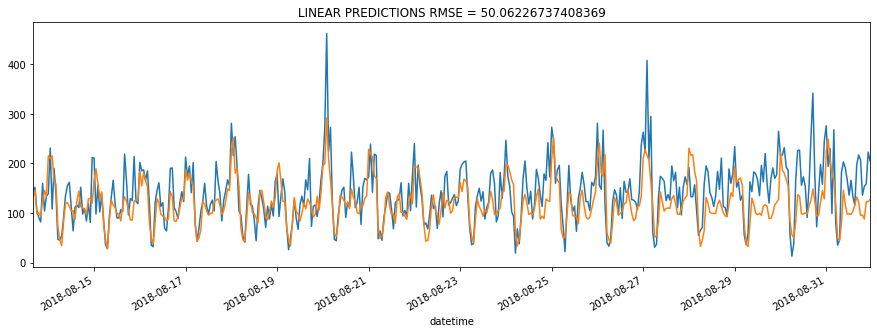

In [19]:
plt.plot(target_test)
pd.Series(random_forest_predictions, index = target_test.index).plot(figsize = (15,5))
plt.title('LINEAR PREDICTIONS RMSE = {}'.format((mean_squared_error(target_test, linear_predictions_test))**0.5))
plt.show()

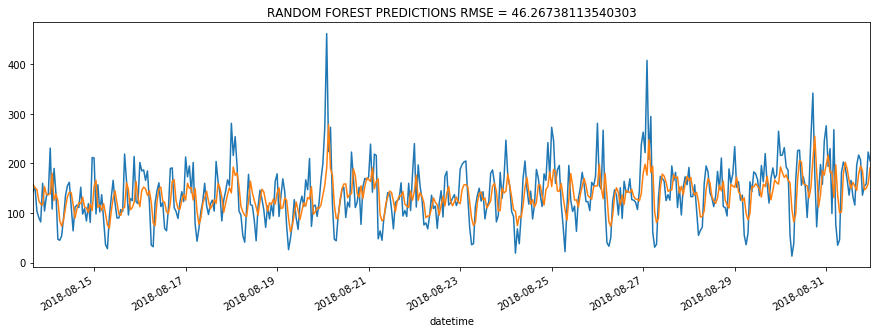

In [20]:
plt.plot(target_test)
pd.Series(linear_predictions_test, index = target_test.index).plot(figsize = (15,5))
plt.title('RANDOM FOREST PREDICTIONS RMSE = {}'.format(((mean_squared_error(target_test, random_forest_predictions))**0.5)))
plt.show()

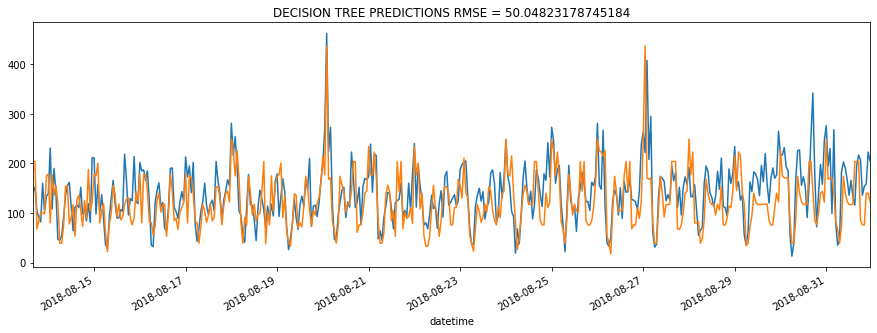

In [21]:
plt.plot(target_test)
pd.Series(decision_tree_predictions, index = target_test.index).plot(figsize = (15,5))
plt.title('DECISION TREE PREDICTIONS RMSE = {}'.format((mean_squared_error(target_test, decision_tree_predictions))**0.5))
plt.show()

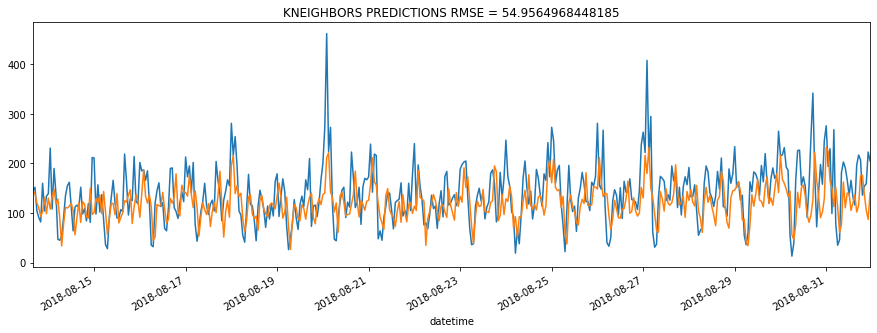

In [22]:
plt.plot(target_test)
pd.Series(KNeighborsRegressor_predictions, index = target_test.index).plot(figsize = (15,5))
plt.title('KNEIGHBORS PREDICTIONS RMSE = {}'.format((mean_squared_error(target_test, KNeighborsRegressor_predictions))**0.5))
plt.show()

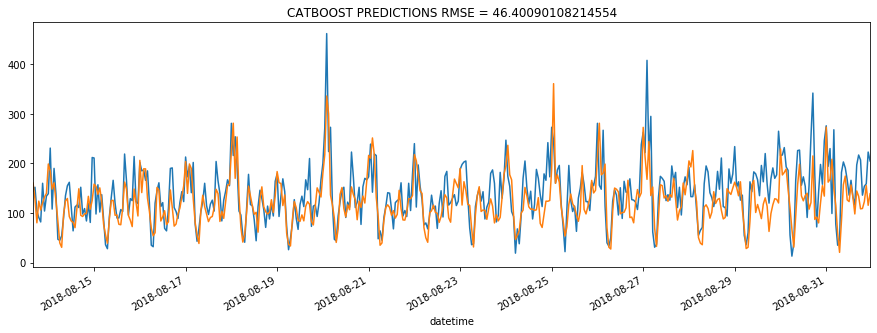

In [23]:
plt.plot(target_test)
pd.Series(CatBoostRegressor_predictions, index = target_test.index).plot(figsize = (15,5))
plt.title('CATBOOST PREDICTIONS RMSE = {}'.format((mean_squared_error(target_test, CatBoostRegressor_predictions))**0.5))
plt.show()

Лучшие значения были у моделей CatBoostRegressor и RandomForestRegressor с подобранными параметрами.